In [3]:
# import libraries
import pandas as pd
import geopandas as gpd 
import json 
from traclus import traclus as tr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import contextily as ctx
from shapely.geometry import LineString

In [4]:
# Variables globales
nrows = 10
# Ruta del archivo CSV
filename = 'C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/train_data/taxis_trajectory/train.csv'

In [5]:
# Leer el archivo CSV
df = pd.read_csv(filename, nrows=nrows, sep=",", low_memory=False)

In [6]:
# Convertir las polilíneas de JSON a listas de coordenadas
df['POLYLINE'] = df['POLYLINE'].apply(lambda x: json.loads(x) if pd.notnull(x) else None)

# Filtrar filas con polilíneas vacías o nulas
df = df[df['POLYLINE'].apply(lambda x: x is not None and len(x) > 0)]

In [7]:
# Preparar las trayectorias para TRACLUS
trayectorias = [np.array(polyline) for polyline in df['POLYLINE']]

100 filas de datos son 2 minutos y 45 segundos,
200 filas de datos son 10 minutos y 15 segundos,
300 filas de datos son 33 minutos y 4 segundos,
400 filas de datos son 40 minutos y 1 segundo,
500 filas de datos son 1 hora y 4 minutos,

In [51]:
import importlib
import TRACLUS_2  as tr2
importlib.reload(tr2)

<module 'TRACLUS_2' from 'c:\\Users\\Álvaro\\Documents\\GitHub\\TFG\\TFG_TRACLUS\\app\\src\\TRACLUS_2.py'>

In [52]:
out = tr2.traclus(trayectorias, min_samples=5)

In [53]:
#from sklearn.cluster import HDBSCAN  clustering_algorithm=HDBSCAN
    
# Ejecutar TRACLUS
out1 = tr.traclus(trayectorias, min_samples=5)

c:\Users\Álvaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\traclus\traclus.py:255: RuntimeWarning: divide by zero encountered in log2
  LH += np.log2(d_euclidean(trajectory[i], trajectory[i+1]))


In [54]:
partitions, segments, dist_matrix, clusters, cluster_assignments, representative_trajectories = out

In [55]:
counter1 = 0
cluster_trayectories = []
# Representacion de las trayectorias pero sin el primer elemento, este parece ser solo un conjunto basura
representative_clusters = representative_trajectories[1:representative_trajectories.__len__()]

# Trayectorias de los clusters en una lista pero sin el primer elemento
for segment in clusters:
    if counter1 == 0:
        counter1 += 1
        continue
    else:
        counter1 += 1
    for part in segment:
        if isinstance(part, np.ndarray):    
            cluster_trayectories.append(part)

In [56]:
""" trayectorias """

' trayectorias '

In [57]:
""" print("Particiones: ", partitions) """

' print("Particiones: ", partitions) '

In [58]:
""" print("Segmentos: ", segments) """

' print("Segmentos: ", segments) '

In [59]:
""" print("Matriz de distancias: ", dist_matrix) """

' print("Matriz de distancias: ", dist_matrix) '

In [60]:
""" print("Clusters: ", clusters) """

' print("Clusters: ", clusters) '

In [61]:
""" print("Asignaciones: ", cluster_assignments) """

' print("Asignaciones: ", cluster_assignments) '

In [62]:
""" print("Trayectorias representativas: ", representative_trajectories) """

' print("Trayectorias representativas: ", representative_trajectories) '

In [63]:
def plot_segments_on_map(segments, cluster_assignments, descart_minun_one=False, leyenda=False):
    # Crear un GeoDataFrame vacío
    gdf = gpd.GeoDataFrame(columns=['geometry', 'cluster_id'])

    # Añadir cada segmento al GeoDataFrame
    for segment, cluster_id in zip(segments , cluster_assignments):
        if descart_minun_one and cluster_id == -1:
            continue
            # Cada 'part' es un segmento dentro del cluster
        if isinstance(segment, np.ndarray):  # Verificar si 'part' es un array de NumPy
            line = LineString(segment)
            gdf = pd.concat([gdf, gpd.GeoDataFrame({'geometry': [line], 'cluster_id': [cluster_id]})], ignore_index=True)

    gdf.crs = "EPSG:4326"
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

    if not gdf.empty:
        # Generar colores para cada cluster
        unique_clusters = gdf['cluster_id'].unique()
        colormap = plt.cm.tab20
        color_dict = {cid: colormap(i / len(unique_clusters)) for i, cid in enumerate(unique_clusters)}

        # Dibujar cada segmento según su cluster_id
        for _, row in gdf.iterrows():
            color = color_dict[row['cluster_id']]
            gdf.loc[gdf.index == _, 'geometry'].plot(ax=ax, linewidth=2, color=color)

        # Añadir leyenda
        if leyenda:    
            legend_elements = [Line2D([0], [0], color=color_dict[cid], lw=2, label=f'Cluster {cid}') for cid in unique_clusters]
            ax.legend(handles=legend_elements, loc='upper left')

        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())
    else:
        print("No hay datos válidos para graficar.")

    ax.set_axis_off()
    plt.show()

In [64]:
def plot_clusters_on_map(clusters, descart_minun_one=False, leyenda=False):
    # Crear un GeoDataFrame vacío
    gdf = gpd.GeoDataFrame(columns=['geometry', 'cluster_id'])

    cluster_id = 0
    # Añadir cada segmento al GeoDataFrame
    for segment in clusters:
        if descart_minun_one and cluster_id == 0:
            cluster_id +=1
            continue
        else:
            cluster_id +=1
        for part in segment:
            # Cada 'part' es un segmento dentro del cluster
            if isinstance(part, np.ndarray):  # Verificar si 'part' es un array de NumPy
                line = LineString(part)
                gdf = pd.concat([gdf, gpd.GeoDataFrame({'geometry': [line], 'cluster_id': [cluster_id]})], ignore_index=True)

    gdf.crs = "EPSG:4326"
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

    if not gdf.empty:
        # Generar colores para cada cluster
        unique_clusters = gdf['cluster_id'].unique()
        colormap = plt.cm.tab20
        color_dict = {cid: colormap(i / len(unique_clusters)) for i, cid in enumerate(unique_clusters)}

        # Dibujar cada segmento según su cluster_id
        for _, row in gdf.iterrows():
            color = color_dict[row['cluster_id']]
            gdf.loc[gdf.index == _, 'geometry'].plot(ax=ax, linewidth=2, color=color)

        # Añadir leyenda   
        if leyenda:     
            legend_elements = [Line2D([0], [0], color=color_dict[cid], lw=2, label=f'Cluster {cid}') for cid in unique_clusters]
            ax.legend(handles=legend_elements, loc='upper left')
        
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())
    else:
        print("No hay datos válidos para graficar.")

    ax.set_axis_off()
    plt.show()

In [65]:
def create_gdf(data):
    valid_geometries = [LineString(x) for x in data if len(x) > 1]
    gdf = gpd.GeoDataFrame(geometry=valid_geometries, crs='EPSG:4326')

    return gdf

In [66]:
def plot_map(data, color, data2=None, color2=None):
    # Crear GeoDataFrame
    gdf = create_gdf(data)
    if data2 is not None:
        gdf2 = create_gdf(data2)
    else:
        gdf2 = None

    # Visualizar en un mapa
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    if gdf2 is not None:
        gdf2.plot(ax=ax, color=color2, alpha=0.5, linewidth=1)
    gdf.plot(ax=ax, color=color, linewidth=2)
    
    # Añadir mapa base
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())
    # ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
    ax.set_axis_off()
    plt.show()

In [67]:
def plot_map_colour(data, cmap='tab20' ,data2=None, cmap2='tab20'):
    # Crear un GeoDataFrame
    gdf = create_gdf(data)
    if data2 is not None:
        gdf2 = create_gdf(data2)
    else:
        gdf2 = None

    # Visualizar en un mapa
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    if gdf2 is not None:
        gdf2.plot(ax=ax, cmap=cmap2, alpha=0.5, linewidth=1)
    gdf.plot(ax=ax, cmap=cmap, linewidth=2)

    # Añadir mapa base
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())
    ax.set_axis_off()
    plt.show()

Visualizar datos en mapas

In [68]:
#plot_map(partitions, 'green')

In [69]:
partitions[0]

array([[-8.618643, 41.141412],
       [-8.622153, 41.143815],
       [-8.627373, 41.144697],
       [-8.631738, 41.148225],
       [-8.629128, 41.15124 ],
       [-8.628759, 41.152518],
       [-8.631144, 41.154489],
       [-8.630829, 41.154498],
       [-8.630838, 41.154489]])

In [70]:
df['POLYLINE'].iloc[0]

[[-8.618643, 41.141412],
 [-8.618499, 41.141376],
 [-8.620326, 41.14251],
 [-8.622153, 41.143815],
 [-8.623953, 41.144373],
 [-8.62668, 41.144778],
 [-8.627373, 41.144697],
 [-8.630226, 41.14521],
 [-8.632746, 41.14692],
 [-8.631738, 41.148225],
 [-8.629938, 41.150385],
 [-8.62911, 41.151213],
 [-8.629128, 41.15124],
 [-8.628786, 41.152203],
 [-8.628687, 41.152374],
 [-8.628759, 41.152518],
 [-8.630838, 41.15268],
 [-8.632323, 41.153022],
 [-8.631144, 41.154489],
 [-8.630829, 41.154507],
 [-8.630829, 41.154516],
 [-8.630829, 41.154498],
 [-8.630838, 41.154489]]

In [71]:
#plot_map(segments, 'purple')

200 filas de datso son 4 minutos y 19 segundos

In [72]:
""" plot_segments_on_map(segments, cluster_assignments, descart_minun_one=True) """

' plot_segments_on_map(segments, cluster_assignments, descart_minun_one=True) '

In [73]:
#plot_segments_on_map(segments, cluster_assignments, leyenda=True)

In [74]:
#plot_clusters_on_map(clusters, True)

In [75]:
#plot_map(representative_trajectories, 'red', df['POLYLINE'], 'blue')

Mostrar cada representacion del cluster con un color diferente

In [76]:
#plot_map_colour(representative_trajectories)

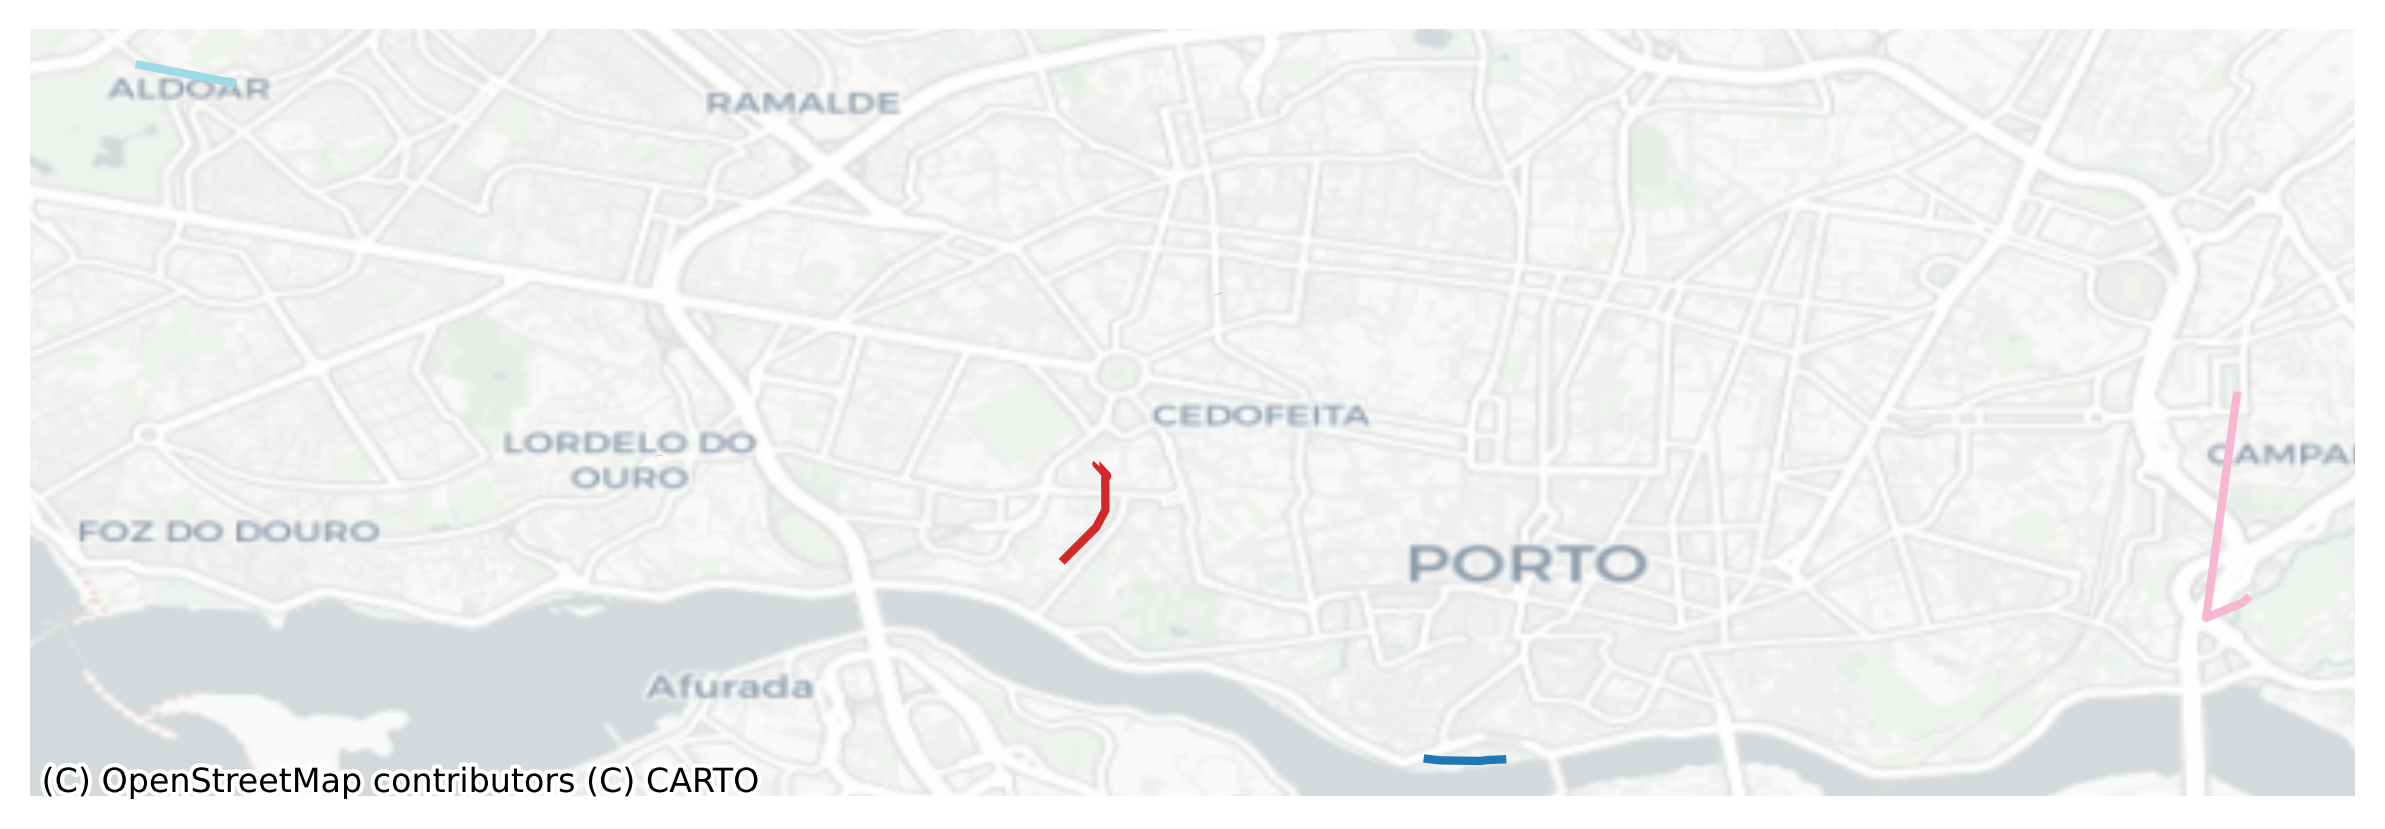

In [77]:
plot_map_colour(representative_clusters)

In [78]:
#plot_map_colour(representative_clusters, data2=cluster_trayectories, cmap2='Blues')

In [79]:
#plot_map_colour(representative_clusters, data2=df['POLYLINE'], cmap2='Blues')

Implementacion de zoom que se puede usar

In [80]:
""" # Asegurarse de que los límites del eje se ajusten a las geometrías que estás mostrando
xmin, ymin, xmax, ymax = gdf.total_bounds
# Calcular el rango y expandirlo
xrange = xmax - xmin
yrange = ymax - ymin

# Aumentar el rango por un factor (por ejemplo, 20% más grande)
expand_factor = 100
xmin -= xrange * expand_factor
xmax += xrange * expand_factor
ymin -= yrange * expand_factor
ymax += yrange * expand_factor

# Aplicar los nuevos límites
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax) """

' # Asegurarse de que los límites del eje se ajusten a las geometrías que estás mostrando\nxmin, ymin, xmax, ymax = gdf.total_bounds\n# Calcular el rango y expandirlo\nxrange = xmax - xmin\nyrange = ymax - ymin\n\n# Aumentar el rango por un factor (por ejemplo, 20% más grande)\nexpand_factor = 100\nxmin -= xrange * expand_factor\nxmax += xrange * expand_factor\nymin -= yrange * expand_factor\nymax += yrange * expand_factor\n\n# Aplicar los nuevos límites\nax.set_xlim(xmin, xmax)\nax.set_ylim(ymin, ymax) '

## Estadisticas de los datos

partitions,                         # Particiones de trayectorias originales


segments,                           # Segmentos de las trayectorias por cambios significativos de la trayectoria


dist_matrix,                        # Matriz de distancias entre segmentos


clusters,                           # Segmentos de las trayectorias agrupados en clusters, por similitud


cluster_assignments,                # Lista que mustra que segmento pertenece a que cluster


representative_trajectories,        # Trayectorias representativas de cada cluster


representative_clusters,            # Trayectorias representativas de cada cluster pero sin el primer elemento, cluster -1, trayectorias no agrupadas


cluster_trayectories                # Trayectorias de los clusters en una lista pero sin el primer elemento

In [81]:
def plot_table(nombres_columnas, datos):
    # Longitud máxima para cada columna
    longitudes_maximas = [max(len(str(x)) for x in columna) for columna in zip(nombres_columnas, *datos)]

    # Imprimir la lista con nombres de columna y fila
    for nombre, longitud in zip(nombres_columnas, longitudes_maximas):
        print(f'{nombre.ljust(longitud)}', end=' ')
    print()
    for fila in datos:
        for elemento, longitud in zip(fila, longitudes_maximas):
            print(f'{str(elemento).ljust(longitud)}', end=' ')
        print()

In [82]:
len_tr = trayectorias.__len__()
len_par = partitions.__len__()
len_seg = segments.__len__()
len_cl = clusters.__len__()

# Lista de nombres de columnas
nombres_columnas = ["", "Trayectorias", "Particiones", "Segmentos", "Clusters"]

# Lista de datos
datos = [
    ["Tamaño:" ,len_tr, len_par, len_seg, len_cl],
    ["Cantidad por trayectoria:", len_tr/len_tr, len_par/len_tr, len_seg/len_tr, len_cl/len_tr],
]

plot_table(nombres_columnas, datos)

                          Trayectorias Particiones Segmentos Clusters 
Tamaño:                   10           10          112       8        
Cantidad por trayectoria: 1.0          1.0         11.2      0.8      


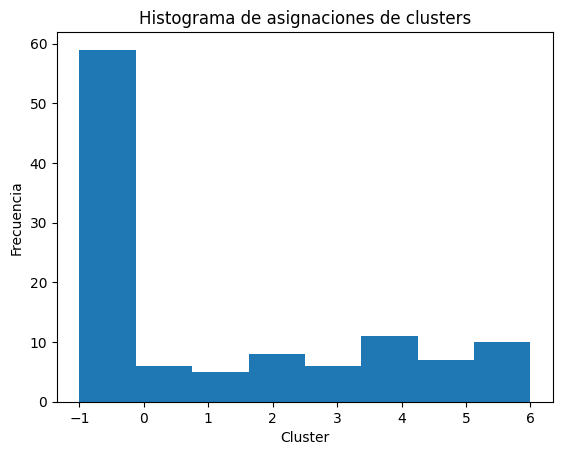

In [83]:
# Crear histograma de asignaciones de clusters
plt.hist(cluster_assignments, bins=len_cl)
plt.title("Histograma de asignaciones de clusters")
plt.xlabel("Cluster")
plt.ylabel("Frecuencia")
plt.show()

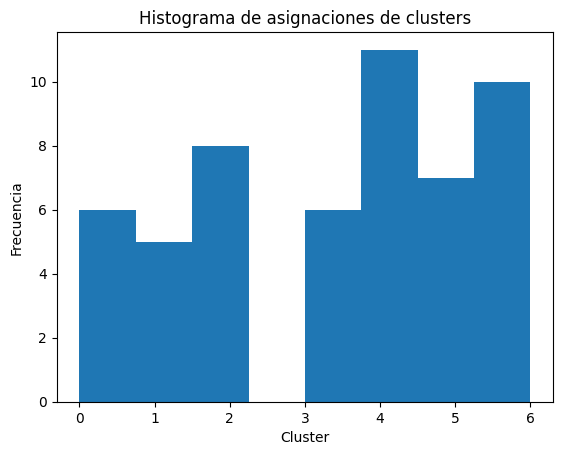

In [84]:
cluster_asig_2 = [asig for asig in cluster_assignments if asig != -1]

# Crear histograma de asignaciones de clusters
plt.hist(cluster_asig_2, bins=len_cl)
plt.title("Histograma de asignaciones de clusters")
plt.xlabel("Cluster")
plt.ylabel("Frecuencia")
plt.show()

In [85]:
# Estadísticas de las asignaciones de clusters
print("Estadísticas de las asignaciones de clusters")

# Lista de nombres de columnas
nombres_columnas = ['Cluster', 'Tamaño', 'Porcentaje']

# Calcular los tamaños de los clusters utilizando np.unique
clusters_unicos, tamaños_clusters = np.unique(cluster_assignments, return_counts=True)

# Calcular el total de asignaciones de clusters
total_asignaciones = len(cluster_assignments)

# Calcular los porcentajes de los tamaños de los clusters y redondear a dos decimales
porcentajes_clusters = np.round((tamaños_clusters / total_asignaciones) * 100, 2)

# Lista de datos
datos = [[cluster, tamaño, porcentaje] for cluster, tamaño, porcentaje in zip(clusters_unicos, tamaños_clusters, porcentajes_clusters)]

plot_table(nombres_columnas, datos)

Estadísticas de las asignaciones de clusters
Cluster Tamaño Porcentaje 
-1      59     52.68      
0       6      5.36       
1       5      4.46       
2       8      7.14       
3       6      5.36       
4       11     9.82       
5       7      6.25       
6       10     8.93       


El porcentaje de segmentos que pertenecen al custer -1 aumenta segun vallan aumentando las trayectorias

## Creacion de gdf que permite visualizar a que trayectria y cluster pertenece cada segmento

In [86]:
# Temporary list to store data before creating GeoDataFrame
gdf_stc_data = []
index = 0

for segment, cluster_id in zip(segments, cluster_assignments):
    if isinstance(segment, np.ndarray):
        line = LineString(segment)
        tray_id_found = False
        
        for i, polyline in enumerate(df['POLYLINE'][index:len(df['POLYLINE'])]):
            # Check if the polyline has 2 or more points
            if i > 0:
                index += 1

            if len(polyline) >= 2:
                tray_line = LineString(polyline)
                
                if tray_line.intersects(line):
                    tray_id = index
                    tray_id_found = True
                    break  # Exit the loop once a matching tray_line is found
            else:
                continue  # Skip this polyline as it cannot form a valid LineString

        if not tray_id_found:
            tray_id = -1  # Indicator for 'not found'

        # Append valid data to the list
        gdf_stc_data.append({'geometry': line, 'cluster_id': cluster_id, 'tray_id': tray_id})

# Create the GeoDataFrame from the collected data
gdf_stc = gpd.GeoDataFrame(gdf_stc_data, columns=['geometry', 'cluster_id', 'tray_id'])

In [87]:
gdf_stc

geometry  cluster_id  tray_id
0    LINESTRING (-8.61864 41.14141, -8.62215 41.14381)          -1        0
1    LINESTRING (-8.62215 41.14381, -8.62737 41.14470)          -1        0
2    LINESTRING (-8.62737 41.14470, -8.63174 41.14822)          -1        0
3    LINESTRING (-8.63174 41.14822, -8.62913 41.15124)           2        0
4    LINESTRING (-8.62913 41.15124, -8.62876 41.15252)           2        0
..                                                 ...         ...      ...
107  LINESTRING (-8.60990 41.14083, -8.61078 41.13755)          -1        9
108  LINESTRING (-8.61078 41.13755, -8.60932 41.13445)          -1        9
109  LINESTRING (-8.60932 41.13445, -8.60799 41.13452)          -1        9
110  LINESTRING (-8.60799 41.13452, -8.60741 41.13453)          -1        9
111  LINESTRING (-8.60741 41.13453, -8.60459 41.13416)          -1        9

[112 rows x 3 columns]

In [88]:
# Segmetos que forma la trayectotia x
gdf_stc.loc[gdf_stc['tray_id'] == 99]    

Empty GeoDataFrame
Columns: [geometry, cluster_id, tray_id]
Index: []

In [89]:
# Trayectorias que forman el cluster y
y = 1
cluster_y = gdf_stc[gdf_stc['cluster_id'] == y]
print(cluster_y)

                                              geometry  cluster_id  tray_id
44   LINESTRING (-8.59254 41.14661, -8.59869 41.14612)           1        3
45   LINESTRING (-8.59869 41.14612, -8.60106 41.14610)           1        3
46   LINESTRING (-8.60106 41.14610, -8.60328 41.14560)           1        3
74   LINESTRING (-8.59747 41.14891, -8.60069 41.14858)           1        6
100  LINESTRING (-8.60430 41.14530, -8.60104 41.14576)           1       -1


## Visualizacion de las trayectorias con sus segmentos por separado

In [90]:
trayectoria_para_visualizar = 0

gdf_stc_fragment = gdf_stc[gdf_stc['tray_id'] == trayectoria_para_visualizar]
gdf_stc_fragment

geometry  cluster_id  tray_id
0  LINESTRING (-8.61864 41.14141, -8.62215 41.14381)          -1        0
1  LINESTRING (-8.62215 41.14381, -8.62737 41.14470)          -1        0
2  LINESTRING (-8.62737 41.14470, -8.63174 41.14822)          -1        0
3  LINESTRING (-8.63174 41.14822, -8.62913 41.15124)           2        0
4  LINESTRING (-8.62913 41.15124, -8.62876 41.15252)           2        0
5  LINESTRING (-8.62876 41.15252, -8.63114 41.15449)           2        0
6  LINESTRING (-8.63114 41.15449, -8.63083 41.15450)           2        0
7  LINESTRING (-8.63083 41.15450, -8.63084 41.15449)           2        0

In [91]:
lista_de_listas = gdf_stc_fragment.apply(lambda row: [list(row['geometry'].coords)], axis=1).tolist()
lista_ = []

for lista in lista_de_listas:
    lista_.append(lista[0])

# lista_

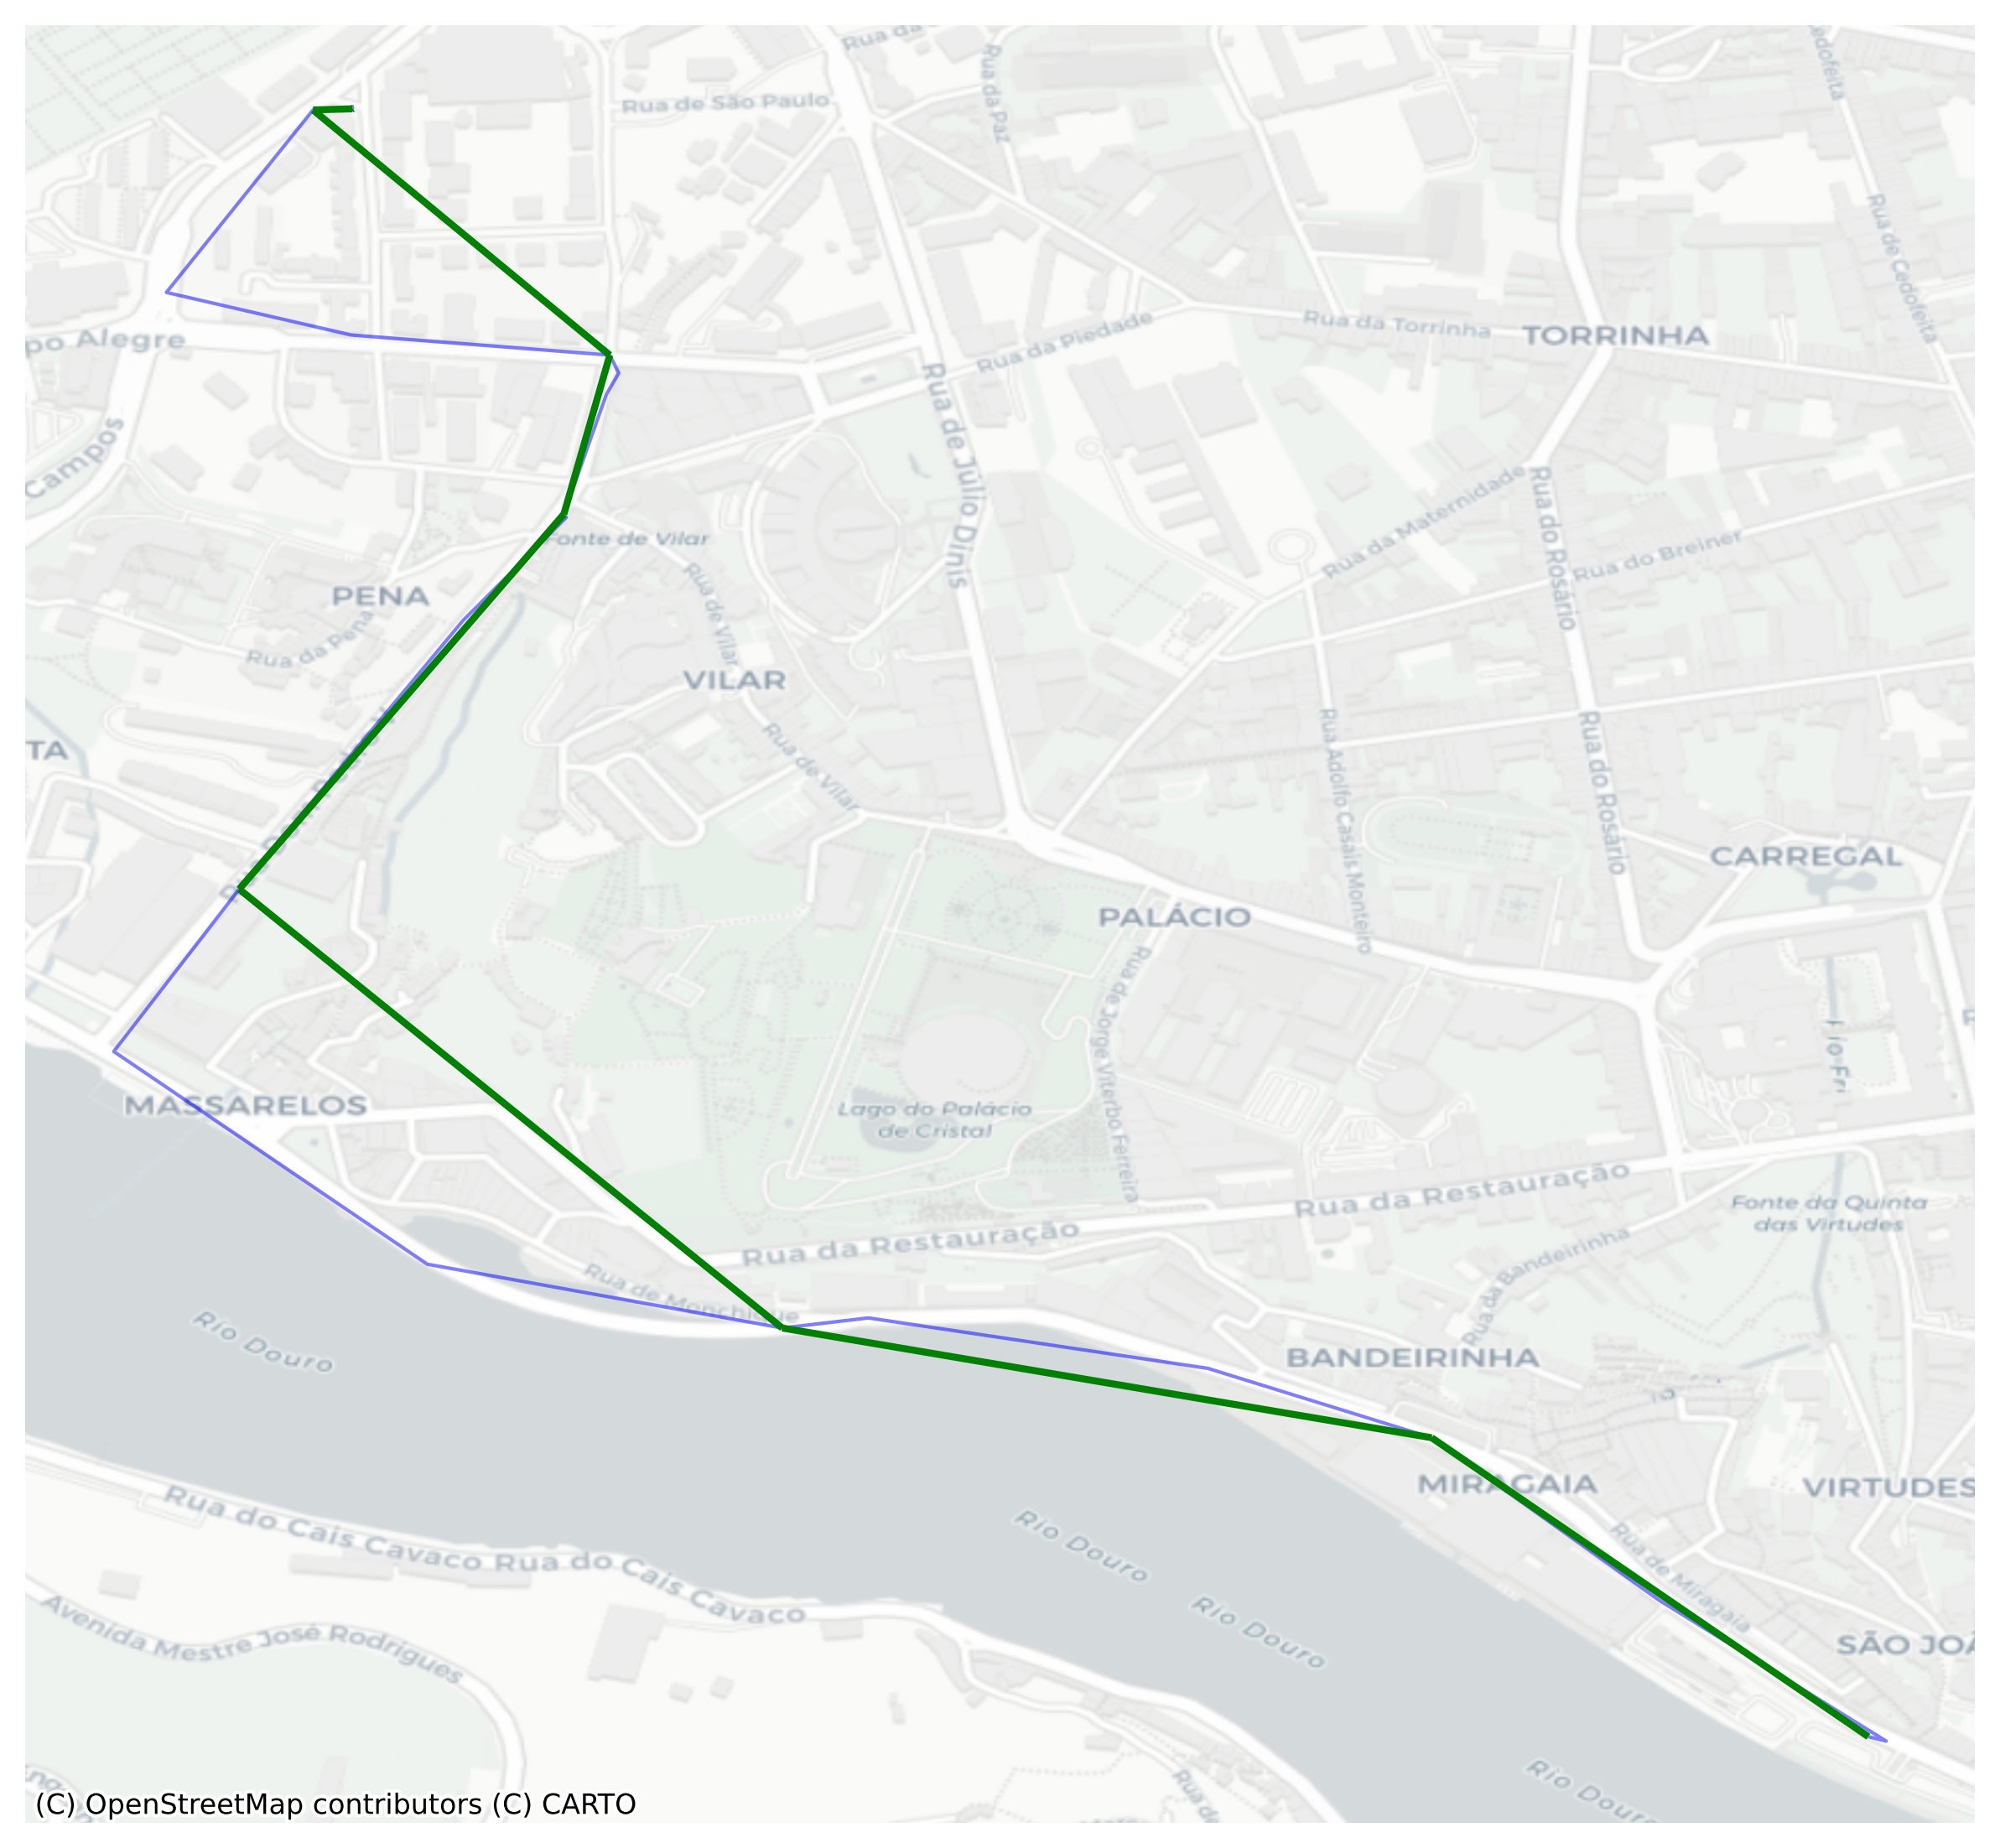

In [92]:
plot_map(lista_, 'green', df['POLYLINE'][trayectoria_para_visualizar:trayectoria_para_visualizar+1], 'blue')